<a href="https://colab.research.google.com/github/dhyeybm/PotholeDetection/blob/master/Tumor_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
%cd /content/gdrive/My Drive/FY_Project

/content/gdrive/My Drive/FY_Project


In [ ]:
!kaggle datasets download -d ahmedhamada0/brain-tumor-detection

 96% 81.0M/84.0M [00:00<00:00, 135MB/s]
100% 84.0M/84.0M [00:00<00:00, 156MB/s]


In [ ]:
!unzip brain-tumor-detection.zip

Archive:  brain-tumor-detection.zip
  inflating: Br35H-Mask-RCNN/TEST/annotations_test.json  
  inflating: Br35H-Mask-RCNN/TEST/y701.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y702.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y703.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y704.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y705.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y706.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y707.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y708.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y709.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y710.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y711.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y712.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y713.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y714.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y715.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y716.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y717.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y718.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y719.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y720.jpg  
  infl

In [ ]:
import os
import glob
import shutil
import random
import pandas as pd
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#%% IMPORTING DATA

def importing_data(path):
    sample = []
    for filename in glob.glob(path):
        #img = Image.open(filename,'r')
        #IMG = np.array(img)
        sample.append(filename)
    return sample

path1 = './no/*.jpg'
path2 = './yes/*.jpg'
path3 = './pred/*.jpg'

train_n = importing_data(path1)
train_y = importing_data(path2)
test = importing_data(path3)

#%% CREATION OF DATASETS

df_train_n = pd.DataFrame({'image':train_n, 'label': 'Healthy'})
df_train_y = pd.DataFrame({'image':train_y, 'label': 'Affected'})
df_test = pd.DataFrame({'image':test})
train_data = pd.concat([df_train_n, df_train_y])
train_data.head()


,image,label
0,./no/No12.jpg,Healthy
1,./no/No13.jpg,Healthy
2,./no/No14.jpg,Healthy
3,./no/No15.jpg,Healthy
4,./no/No17.jpg,Healthy


In [ ]:
#%% TRAIN-VALIDATION SPLIT (90% TRAIN - 10% VALIDATION)

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(train_data,
                                  test_size = 0.1,
                                  shuffle = True,
                                  random_state = 42)

In [ ]:
import keras
from keras.metrics import AUC, Recall, Precision
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D , MaxPooling2D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop

def build_model():
    
    '''Sequential Model creation'''
    Cnn = Sequential()
    
    Cnn.add(Conv2D(64,(5,5), activation = 'relu', padding = 'same',
                   strides=(2,2), input_shape = [224,224,1]))
    Cnn.add(MaxPooling2D(2))
    Cnn.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(Conv2D(256,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(MaxPooling2D(2))
    #Cnn.add(GlobalAveragePooling2D())
    Cnn.add(Flatten())
    Cnn.add(Dense(64, activation = 'relu'))
    Cnn.add(Dropout(0.4))
    Cnn.add(Dense(32, activation = 'relu'))
    Cnn.add(Dropout(0.4))
    Cnn.add(Dense(2, activation = 'softmax'))
    
    return Cnn

keras_model = build_model()
keras_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       204928    
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         819456    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 256)        0         
 2D)                                                    

In [ ]:
def Model_fit(train_data, val_data):
    
    keras_model = None
    
    keras_model = build_model()
    
    '''Compiling the model'''
    
    keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics =['acc'])
    
    es = EarlyStopping(monitor='val_loss', mode='min',
                       patience=2,
                       restore_best_weights=True,
                       verbose=1)
                       
    
    checkpoint_cb = ModelCheckpoint("Brain_model_best.h5",
                                    save_best_only=True)
    
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 3,
                                  min_lr = 1e-5,
                                  mode = 'min',
                                  verbose=1)
                                  
    
    history = keras_model.fit(train_data,
                              validation_data = val_data,
                              epochs= 50,
                              batch_size = 10,
                              callbacks=[es, checkpoint_cb, reduce_lr])
                              
    
      
    return history

In [29]:
from keras.preprocessing.image import ImageDataGenerator

k_fold = 3
IMG_SIZE = 224
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2

def CV_training(train_data, val_data):
    
    cv_histories = []
    
    for i in range(0,k_fold):
    
        datagen = ImageDataGenerator(rescale = 1./255)
    
        train_set = datagen.flow_from_dataframe(train_data,
                                                # directory = './*.jpg',
                                                x_col = 'image',
                                                y_col = 'label',
                                                target_size = size,
                                                color_mode = 'grayscale',
                                                class_mode = 'sparse',
                                                batch_size = 10,
                                                shuffle = True,
                                                interpolation = 'bilinear')
        
        val_set = datagen.flow_from_dataframe(val_data,
                                              # directory = './*.jpg',
                                              x_col = 'image',
                                              y_col = 'label',
                                              target_size = size,
                                              color_mode = 'grayscale',
                                              class_mode = 'sparse',
                                              batch_size = 10,
                                              shuffle = True,
                                              interpolation = 'bilinear')
        print("Training on Fold: ",i+1)
    
        cv_histories.append(Model_fit(train_set, val_set))
    
    return cv_histories

cv_results = CV_training(X_train,X_val)


Found 2700 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Training on Fold:  1
Epoch 1/50
270/270 [==============================] - 146s 536ms/step - loss: 0.6349 - acc: 0.6404 - val_loss: 0.5034 - val_acc: 0.7567 - lr: 1.0000e-04
Epoch 2/50
270/270 [==============================] - 145s 538ms/step - loss: 0.5330 - acc: 0.7337 - val_loss: 0.4077 - val_acc: 0.8633 - lr: 1.0000e-04
Epoch 3/50
270/270 [==============================] - 145s 538ms/step - loss: 0.4504 - acc: 0.7967 - val_loss: 0.3067 - val_acc: 0.8900 - lr: 1.0000e-04
Epoch 4/50
270/270 [==============================] - 146s 539ms/step - loss: 0.3574 - acc: 0.8500 - val_loss: 0.2573 - val_acc: 0.9000 - lr: 1.0000e-04
Epoch 5/50
270/270 [==============================] - 146s 542ms/step - loss: 0.2804 - acc: 0.8952 - val_loss: 0.1892 - val_acc: 0.9433 - lr: 1.0000e-04
Epoch 6/50
270/270 [==============================] - 146s 541ms/step - loss: 0.1894 - acc: 0

In [31]:
def acc_results(results):
    i = 0
    for fold in cv_results:
        print('Val_Acc Folder '+ str(i) + ' =', max(fold.history['val_acc']))
        i += 1
        
acc_results(cv_results)

Val_Acc Folder 0 = 0.9700000286102295
Val_Acc Folder 1 = 0.9666666388511658
Val_Acc Folder 2 = 0.9733333587646484


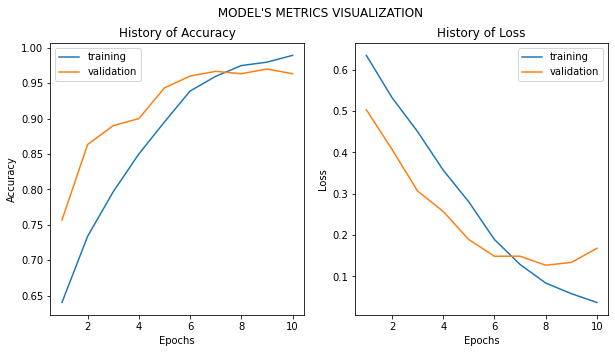

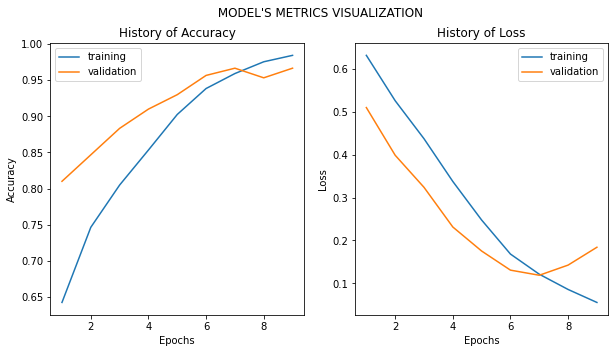

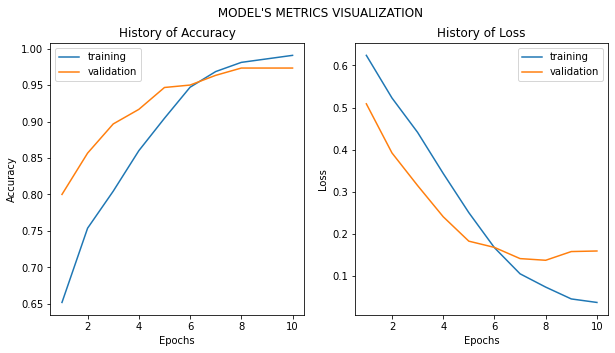

In [32]:
#%% LOOKING AT THE ACCURACY-LOSS PLOTS FOR EACH FOLD

def Acc_Loss_Plot(results):
    
    for fold in results:
        
        acc = fold.history['acc']
        val_acc = fold.history['val_acc']
        loss = fold.history['loss']
        val_loss = fold.history['val_loss']
    
        fig, (ax1, ax2) = plt.subplots(1,2, figsize= (10,5))
        fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

        ax1.plot(range(1, len(acc) + 1), acc)
        ax1.plot(range(1, len(val_acc) + 1), val_acc)
        ax1.set_title('History of Accuracy')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy')
        ax1.legend(['training', 'validation'])


        ax2.plot(range(1, len(loss) + 1), loss)
        ax2.plot(range(1, len(val_loss) + 1), val_loss)
        ax2.set_title('History of Loss')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend(['training', 'validation'])
        plt.show()
    
Acc_Loss_Plot(cv_results)

In [35]:
#%% LOADING THE MODEL

import keras

keras_model = keras.models.load_model('Brain_model_best.h5')
keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                    loss='sparse_categorical_crossentropy', metrics =[ 'acc'])

# Predictions on the test set

datagen = ImageDataGenerator(rescale = 1./255)

test_set = datagen.flow_from_dataframe(df_test,
                                      #  directory = '//kaggle/input/brain-tumor-detection/*.jpg',
                                       x_col = 'image',
                                       y_col = None,
                                       target_size = size,
                                       color_mode = 'grayscale',
                                       class_mode = None,
                                       batch_size = 10,
                                       shuffle = False,
                                       interpolation = 'bilinear')

predictions = keras_model.predict(test_set)
predictions = predictions.argmax(axis=-1)
print("Where 0 = 'Affected'")
print("Where 1 = 'Healthy'")
print(predictions)

Found 60 validated image filenames.
Where 0 = 'Affected'
Where 1 = 'Healthy'
[1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 0 0 0]


In [36]:
pred = []
[pred.append('Healthy') if i == 1 else pred.append('Affected') for i in predictions]
print(pred)

['Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Affected', 'Affected']


In [37]:
images10 = [test_set[0][0],test_set[0][1],test_set[0][2],test_set[0][3],test_set[0][4],
            test_set[0][5],test_set[0][6],test_set[0][7],test_set[0][8],test_set[0][9]]
            
prediction10 = pred[0:9]
final_pred = zip(images10,prediction10)

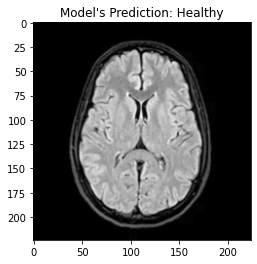

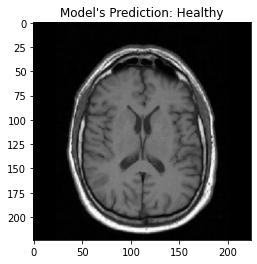

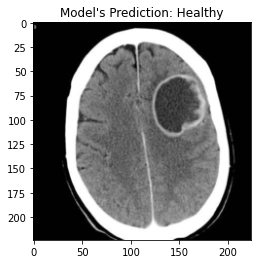

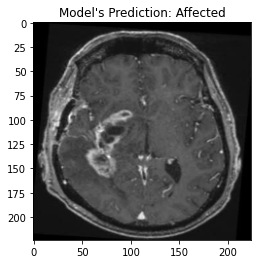

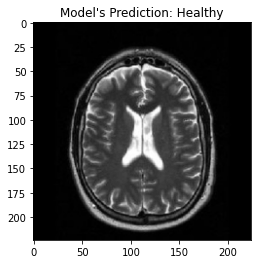

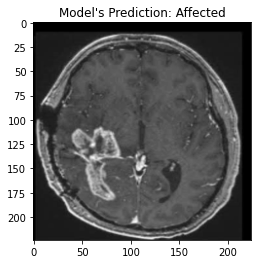

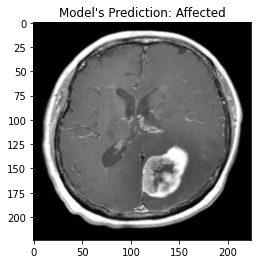

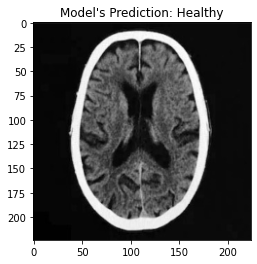

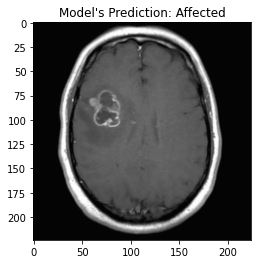

In [38]:
def pre_visualization(data, predictions):
    
    for image,pred in final_pred:
        plt.imshow(image.reshape(224,224), cmap = 'gray')
        plt.title("Model's Prediction: " + str(pred))
        plt.show()
        
pre_visualization(images10,prediction10)